In [26]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

In [27]:
symbol = 'NFLX'
START = '2010-01-01'
END = date.today().strftime("%Y-%m-%d")

data = yf.download(symbol, START, END)
data.reset_index(inplace=True)
data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.931429,7.961429,7.565714,7.640000,7.640000,17239600
1,2010-01-05,7.652857,7.657143,7.258571,7.358571,7.358571,23753100
2,2010-01-06,7.361429,7.672857,7.197143,7.617143,7.617143,23290400
3,2010-01-07,7.731429,7.757143,7.462857,7.485714,7.485714,9955400
4,2010-01-08,7.498571,7.742857,7.465714,7.614286,7.614286,8180900
...,...,...,...,...,...,...,...
3606,2024-05-02,556.020020,565.460022,555.590027,565.150024,565.150024,3068200
3607,2024-05-03,566.000000,580.260010,565.159973,579.340027,579.340027,3307500
3608,2024-05-06,581.820007,597.340027,580.250000,596.969971,596.969971,3686300
3609,2024-05-07,596.280029,606.049988,591.320007,606.000000,606.000000,3614100


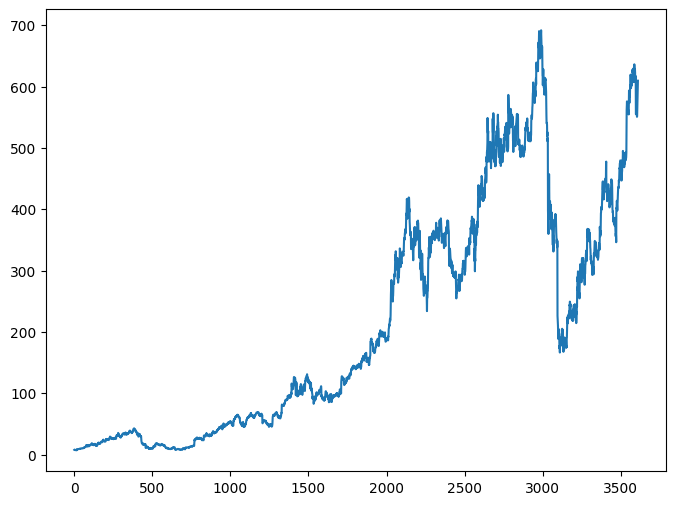

In [28]:
plt.figure(figsize=(8,6))
plt.plot(data.Close)
plt.show()

In [29]:
data.dropna(inplace=True)

In [30]:
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [31]:
data_train.shape[0]

2888

In [32]:
data_test.shape[0]

723

In [33]:
scaler = MinMaxScaler(feature_range=(0,1))

In [34]:
data_train_scale = scaler.fit_transform(data_train)

In [35]:
x = []
y = []

period = 50

for i in range(period, data_train_scale.shape[0]):
    x.append(data_train_scale[i-period:i])
    y.append(data_train_scale[i,0])


In [36]:
x, y = np.array(x), np.array(y)

In [37]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape = ((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1))

In [38]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [39]:
model.fit(x,y, epochs = 50, batch_size =32, verbose =1)

Epoch 1/50
89/89 [==============================] - 17s 133ms/step - loss: 0.0314
Epoch 2/50
89/89 [==============================] - 12s 134ms/step - loss: 0.0058
Epoch 3/50
89/89 [==============================] - 12s 134ms/step - loss: 0.0056
Epoch 4/50
89/89 [==============================] - 12s 134ms/step - loss: 0.0048
Epoch 5/50
89/89 [==============================] - 11s 126ms/step - loss: 0.0043
Epoch 6/50
89/89 [==============================] - 12s 138ms/step - loss: 0.0042
Epoch 7/50
89/89 [==============================] - 12s 137ms/step - loss: 0.0037
Epoch 8/50
89/89 [==============================] - 14s 159ms/step - loss: 0.0035
Epoch 9/50
89/89 [==============================] - 12s 134ms/step - loss: 0.0039
Epoch 10/50
89/89 [==============================] - 12s 135ms/step - loss: 0.0035
Epoch 11/50
89/89 [==============================] - 13s 151ms/step - loss: 0.0035
Epoch 12/50
89/89 [==============================] - 13s 151ms/step - loss: 0.0035
Epoch 13/50
8

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50, 60)            26640     
                                                                 
 dropout_5 (Dropout)         (None, 50, 60)            0         
                                                                 
 lstm_6 (LSTM)               (None, 50, 80)            45120     
                                                                 
 dropout_6 (Dropout)         (None, 50, 80)            0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

In [41]:
model.save(f'Model_{period}.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
pas_n_days = data_train.tail(period)

In [43]:
data_test = pd.concat([pas_n_days, data_test], ignore_index=True)

In [44]:
data_test_scale  =  scaler.fit_transform(data_test)

In [45]:
x = []
y = []

for i in range(period, data_test_scale.shape[0]):
    x.append(data_test_scale[i-period:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)

In [46]:
y_predict = model.predict(x)

23/23 [==============================] - 1s 36ms/step


In [47]:
scale =1/scaler.scale_

In [48]:
y_predict = y_predict*scale

In [49]:
y = y*scale

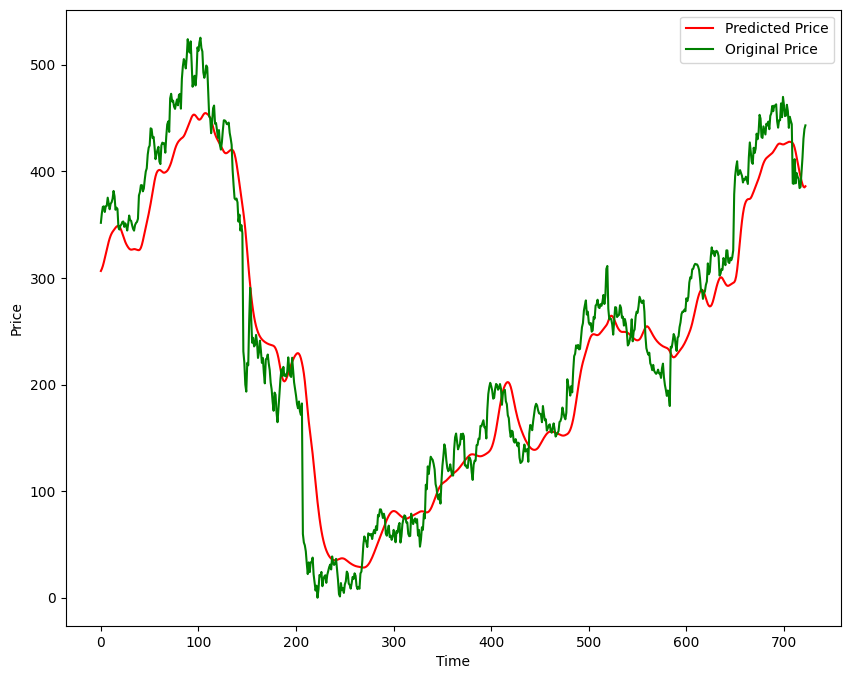

In [50]:
plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()